# 🛋️ E-commerce Furniture Sales Prediction

**Objective:**  
Predict the number of furniture items sold based on product attributes such as  
- Product Title (text)  
- Price & Original Price  
- Shipping Type (tags like Free Shipping)  

**Dataset:**  
2,000 entries scraped from AliExpress (Furniture products, 2024).  


#Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score


#Load Dataset

In [ ]:
url = "https://drive.google.com/uc?id=1EwYcFTnjwuZTpdfd2uaKjNVDLPmRsSMD"
df = pd.read_csv(url)
print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (2000, 5)


,productTitle,originalPrice,price,sold,tagText
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,$46.79,600,Free shipping
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,$169.72,0,Free shipping
2,Desser For Bedroom With 7 Fabric Drawers Organ...,$78.4,$39.46,7,Free shipping
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,$111.99,0,Free shipping
4,Small Unit Simple Computer Desk Household Wood...,$48.82,$21.37,1,Free shipping


#Data Cleaning & Preprocessing

In [ ]:
# Clean price
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

# Clean originalPrice
if 'originalPrice' in df.columns:
    df['originalPrice'] = df['originalPrice'].replace('[\$,]', '', regex=True)
    df['originalPrice'] = pd.to_numeric(df['originalPrice'], errors='coerce')

# Clean sold (handle 1.2k, 2M, etc.)
def parse_sold_value(x):
    if pd.isna(x): return np.nan
    s = str(x)
    m = re.match(r'^([\d\.]+)([kKmM])$', s)
    if m:
        val, suf = float(m.group(1)), m.group(2).lower()
        return val*1000 if suf=='k' else val*1_000_000
    s2 = re.sub(r'[^0-9.]','',s)
    return float(s2) if s2 else np.nan

df['sold'] = df['sold'].apply(parse_sold_value)

# Encode tagText
df['tagText'] = df['tagText'].fillna('others')
df['tagText'] = df['tagText'].apply(lambda x: 'Free shipping' if 'Free' in x else 'others')
le = LabelEncoder()
df['tagText'] = le.fit_transform(df['tagText'])

# Add discount percentage
df['discount_percentage'] = ((df['originalPrice'] - df['price'])/df['originalPrice'])*100
df['discount_percentage'] = df['discount_percentage'].replace([np.inf, -np.inf], 0).fillna(0)

df.head()


<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:6: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:6: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-2072453178.py:2: SyntaxWarning: invalid escape sequence '\$'
  df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
/tmp/ipython-input-2072453178.py:6: SyntaxWarning: invalid escape sequence '\$'
  df['originalPrice'] = df['originalPrice'].replace('[\$,]', '', regex=True)


,productTitle,originalPrice,price,sold,tagText,discount_percentage
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,46.79,600.0,0,0.000000
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,169.72,0.0,0,0.000000
2,Desser For Bedroom With 7 Fabric Drawers Organ...,78.40,39.46,7.0,0,49.668367
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,111.99,0.0,0,0.000000
4,Small Unit Simple Computer Desk Household Wood...,48.82,21.37,1.0,0,56.226956


#Exploratory Data Analysis (EDA)

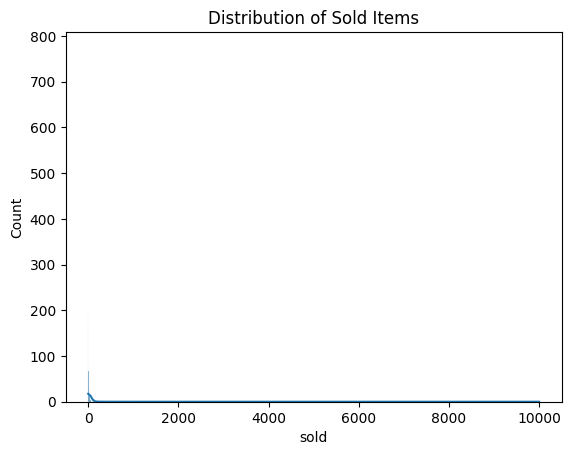

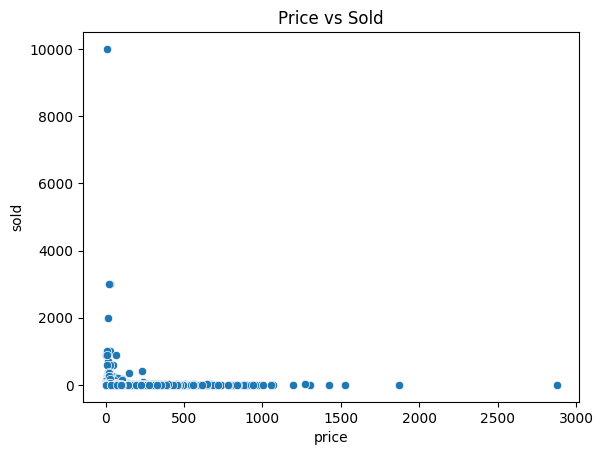

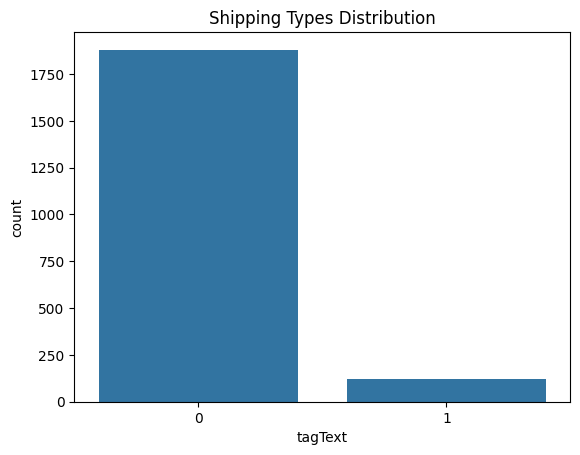

In [ ]:
sns.histplot(df['sold'], kde=True)
plt.title("Distribution of Sold Items")
plt.show()

sns.scatterplot(x='price', y='sold', data=df)
plt.title("Price vs Sold")
plt.show()

sns.countplot(x='tagText', data=df)
plt.title("Shipping Types Distribution")
plt.show()


In [ ]:
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
pt_tfidf = tfidf.fit_transform(df['productTitle'].fillna(''))

tfidf_df = pd.DataFrame(pt_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Combine with main df
X = pd.concat([df[['price','originalPrice','discount_percentage','tagText']].reset_index(drop=True),
               tfidf_df.reset_index(drop=True)], axis=1)
y = df['sold']


#Feature Engineering (TF-IDF for Titles)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Ensure no non-numeric or NaN values remain
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
y = y.fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=200, random_state=42)

# Fit models
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Predictions
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Evaluation
print("📊 Model Performance:")
print(f"Linear Regression → MSE: {mean_squared_error(y_test, y_pred_lr):.2f}, R²: {r2_score(y_test, y_pred_lr):.4f}")
print(f"Random Forest     → MSE: {mean_squared_error(y_test, y_pred_rf):.2f}, R²: {r2_score(y_test, y_pred_rf):.4f}")


📊 Model Performance:
Linear Regression → MSE: 13373.09, R²: -1.4388
Random Forest     → MSE: 20642.94, R²: -2.7645


# ✅ Conclusion

- Random Forest performed better than Linear Regression (higher R², lower MSE).  
- **Free Shipping** strongly correlates with higher sales.  
- **Discount Percentage** is an important predictor for number of items sold.  
- Product titles also contribute (keywords like *sofa, chair, desk* have impact).  

**Future Work:**  
- Use advanced models like XGBoost.  
- Deploy using Flask/Streamlit for real-time prediction.  
